In [1]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
# training path
train_path = 'dataset/train'
test_path = 'dataset/test'

train_img_list = os.listdir(train_path)
test_img_list = os.listdir(test_path)

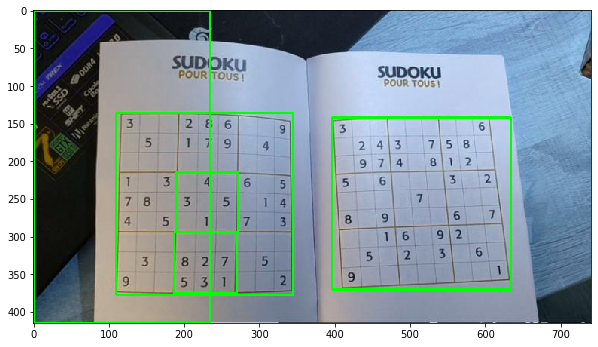

In [3]:
img = cv2.imread(os.path.join(train_path, train_img_list[0]))

# Convert Images to Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Do Gaussian Blur in order to remove noise
gray = cv2.GaussianBlur(gray, (5, 5), 0)
# do adaptive thresholding and convert images to binary
gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
             cv2.THRESH_BINARY,11,2)

# convert to black on white 
gray = cv2.bitwise_not(gray, gray)
# dilate the gridlines
#kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
#gray = cv2.dilate(gray, kernel, iterations = 1)

# find contours (Sudoku Grid)
contours,hierarchy = cv2.findContours(gray, 1, 2)
contours = sorted(contours, key=cv2.contourArea, reverse=True) # sort contours by area
polygon_arr = contours[0:5]  # extract up to 5 sudoku grid at once

cropped_arr = []
bbox_arr = []
orig_gray = gray.copy()
# enumerate to draw rectangle and crop
for polygon in polygon_arr:
    x,y,w,h = cv2.boundingRect(polygon)
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    bbox_arr.append((x,y,w,h))
    cropped_arr.append(orig_gray[y:y+h, x:x+w])
    
plt.figure(figsize=(10,10))
plt.imshow(img)

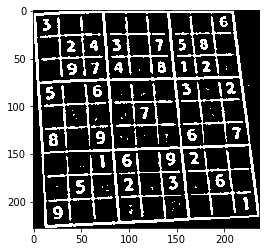

In [4]:
plt.imshow(cropped_arr[1], 'gray')

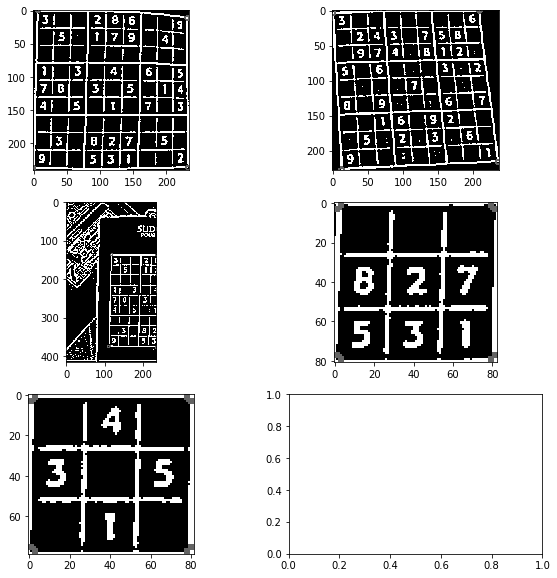

In [5]:
fig,ax = plt.subplots(3,2, figsize=(10,10))
ax = ax.ravel()
all_edges = []

for i in range(5):
    # detect edges
    img1 = cropped_arr[i].copy()

    # find contours (Sudoku Grid)
    contours,hierarchy = cv2.findContours(img1, 1, 2)
    contours = sorted(contours, key=cv2.contourArea, reverse=True) # sort contours by area
    polygon = np.array(contours[0]).reshape(-1,2) #take the largest contour region

    sums = [elem[0] + elem[1] for elem in polygon] # X + Y
    diff1 = [elem[0] - elem[1] for elem in polygon] # X - Y

    top_left = np.argmin(sums) # smallest X + Y values
    bottom_right = np.argmax(sums) # largest X + Y values
    bottom_left = np.argmin(diff1) # smallest X - Y values
    top_right = np.argmax(diff1) # largest X - Y values

    # convert to tuple
    edges = [tuple(polygon[top_left]), tuple(polygon[top_right]), 
             tuple(polygon[bottom_left]), tuple(polygon[bottom_right])]
    all_edges.append(edges)

    # draw edges with gray circle
    for elem_edge in edges:
        cv2.circle(img1, elem_edge, 3, (100,100,255), 2)

    ax[i].imshow(img1, 'gray')

In [6]:
# filter only valid images
valid_sudoku_images = list(range(5))
to_remove = []

# check if edges are within 50 pixels in the corner.
for elem in valid_sudoku_images:
    if all_edges[elem][0][0] > 50 or all_edges[elem][0][1] > 50: # top left of image not very close to edge
        to_remove.append(elem)

valid_sudoku_images = [x for x in valid_sudoku_images if x not in to_remove]  # remove invalid

img_size_area = [elem.shape[0] * elem.shape[1] for elem in cropped_arr] # find area
max_area = np.max(img_size_area) # get maximum area
for elem in valid_sudoku_images:
    if img_size_area[elem] / max_area < 0.5: # less than 50% of max area
        to_remove.append(elem)

valid_sudoku_images = [x for x in valid_sudoku_images if x not in to_remove] # remove invalid

In [7]:
print('valid sudoku images: ', valid_sudoku_images)
cropped_arr = [x for idx, x in enumerate(cropped_arr) if idx in valid_sudoku_images]
print('len cropped arr', len(cropped_arr))

valid sudoku images:  [0, 1]
len cropped arr 2


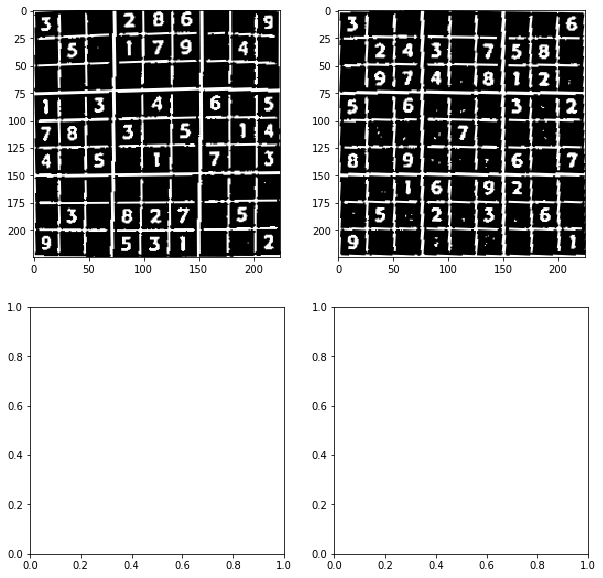

In [8]:
all_M = []
fig,ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.ravel()
final_proc = []

for idx, elem in enumerate(valid_sudoku_images):    
    # transforms image from tilted to straight
    pts1 = np.float32(all_edges[elem])
    #pts1 = np.float32([polygon[top_left], polygon[top_right], polygon[bottom_left], polygon[bottom_right]]) # original box edge
    pts2 = np.float32([[0,0],[225,0],[0,225],[225,225]])  # destination output

    # M is matrix for transformation
    M = cv2.getPerspectiveTransform(pts1,pts2)
    all_M.append(M)

    # output
    dst = cv2.warpPerspective(cropped_arr[idx],M,(225,225))
    final_proc.append(dst)
    ax[idx].imshow(dst, 'gray')

In [9]:
board_arr = []
for board in final_proc:
    temp = []
    for i in range(9):
        lc = i * 25
        for j in range(9):
            rc = j * 25
            temp.append(board[lc:lc+25, rc:rc+25]) # add them row wise
    board_arr.append(temp)

board_arr = np.array(board_arr)

In [10]:
board_arr.shape

(2, 81, 25, 25)

In [11]:
final_board_arr = []
for idx, elem in enumerate(board_arr):
    temp = board_arr[idx][:,2:23, 2:23] # cut 2 pixel from each edge
    final_board_arr.append(temp)
    
final_board_arr = np.array(final_board_arr)

In [12]:
final_board_arr.shape

(2, 81, 21, 21)

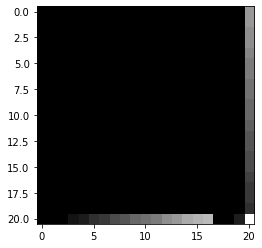

In [13]:
plt.imshow(final_board_arr[0][2], 'gray')

In [14]:
sudoku_board = []

for i in range(final_board_arr.shape[0]):
    temp = []
    for j in range(final_board_arr.shape[1]):
        if len(np.where(final_board_arr[i][j][7:17, 7:17].ravel() == 0)[0])/100 > 0.8:  # percentage of 0 which is black
            temp.append('X')
        else:
            temp.append('NUM')
    sudoku_board.append(temp)

In [15]:
np.array(sudoku_board).shape

(2, 81)

In [16]:
sudoku_board[0]

['NUM',
 'X',
 'X',
 'NUM',
 'NUM',
 'NUM',
 'X',
 'X',
 'NUM',
 'X',
 'NUM',
 'X',
 'NUM',
 'NUM',
 'NUM',
 'X',
 'NUM',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'NUM',
 'X',
 'NUM',
 'X',
 'NUM',
 'X',
 'NUM',
 'X',
 'NUM',
 'NUM',
 'NUM',
 'X',
 'NUM',
 'X',
 'NUM',
 'X',
 'NUM',
 'NUM',
 'NUM',
 'X',
 'NUM',
 'X',
 'NUM',
 'X',
 'NUM',
 'X',
 'NUM',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'NUM',
 'X',
 'NUM',
 'NUM',
 'NUM',
 'X',
 'NUM',
 'X',
 'NUM',
 'X',
 'X',
 'NUM',
 'NUM',
 'NUM',
 'X',
 'X',
 'NUM']